# Dart Target 

## Description

Detect the coordinates of this dart target center


## Group ID

Grupo 1

* Nuno Gonçalo Machado Rodrigues pg50667
* João Carlos Fernandes Novais pg53907

In [1]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np
import math


(708, 1052)


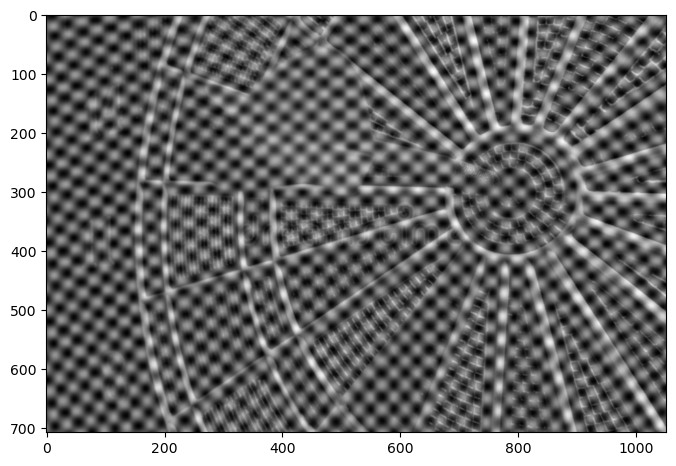

In [2]:
fname = 'DartTarget-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

# Notch Filters

Image Shape = (708, 1052)


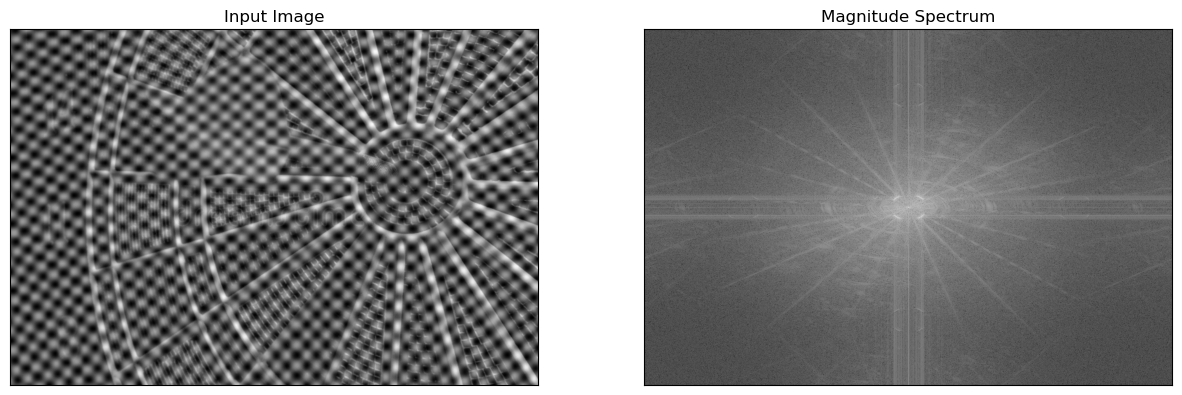

In [3]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

print('Image Shape =', img.shape)
# convert the image representation to SPFP
img_float32 = np.float32(img)
# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)
# display the image and the spectrum
fig = plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         
### Apply Notch filters
# several notch filters can be composited by multiplication



## Escolha do Filtro a Aplicar

Ao olhar para o espectro de magnitude da imagem que nos foi dada, reparamos que, perto do centro, havia uma zona em que era mais acentuada que se localizava na zona das frequências mais baixas, pelo que decidimos fazer um filtro passa alto, com um raio de 50 pixeis centrado nas coordenadas (0,0), uma vez que achamos que iria levar a uma imagem em que as linhas do alvo seriam mais distinguíveis.

[[135 135 131 ... 167 174 174]
 [ 36  36  31 ...  71  80  83]
 [ 36  36  31 ...  72  80  83]
 ...
 [112 112 106 ... 163 163 161]
 [108 108 103 ... 160 162 160]
 [108 108 103 ... 160 161 160]] [[ 80.48479    90.52705    93.49376   ... 126.06679   145.305
  152.0936   ]
 [ 96.72192    87.28092    87.20291   ...  44.797062   21.212917
    8.324751 ]
 [ 72.43063    63.16949    63.537155  ...  19.679682    2.567585
   15.861485 ]
 ...
 [ 39.6711     25.153244   21.485844  ...  34.618755   42.281433
   48.45017  ]
 [ 26.267376   13.654537    9.875565  ...  55.155487   65.39135
   69.84996  ]
 [  1.4467874   9.655869   11.808781  ...  83.45063    90.69025
   96.03151  ]]


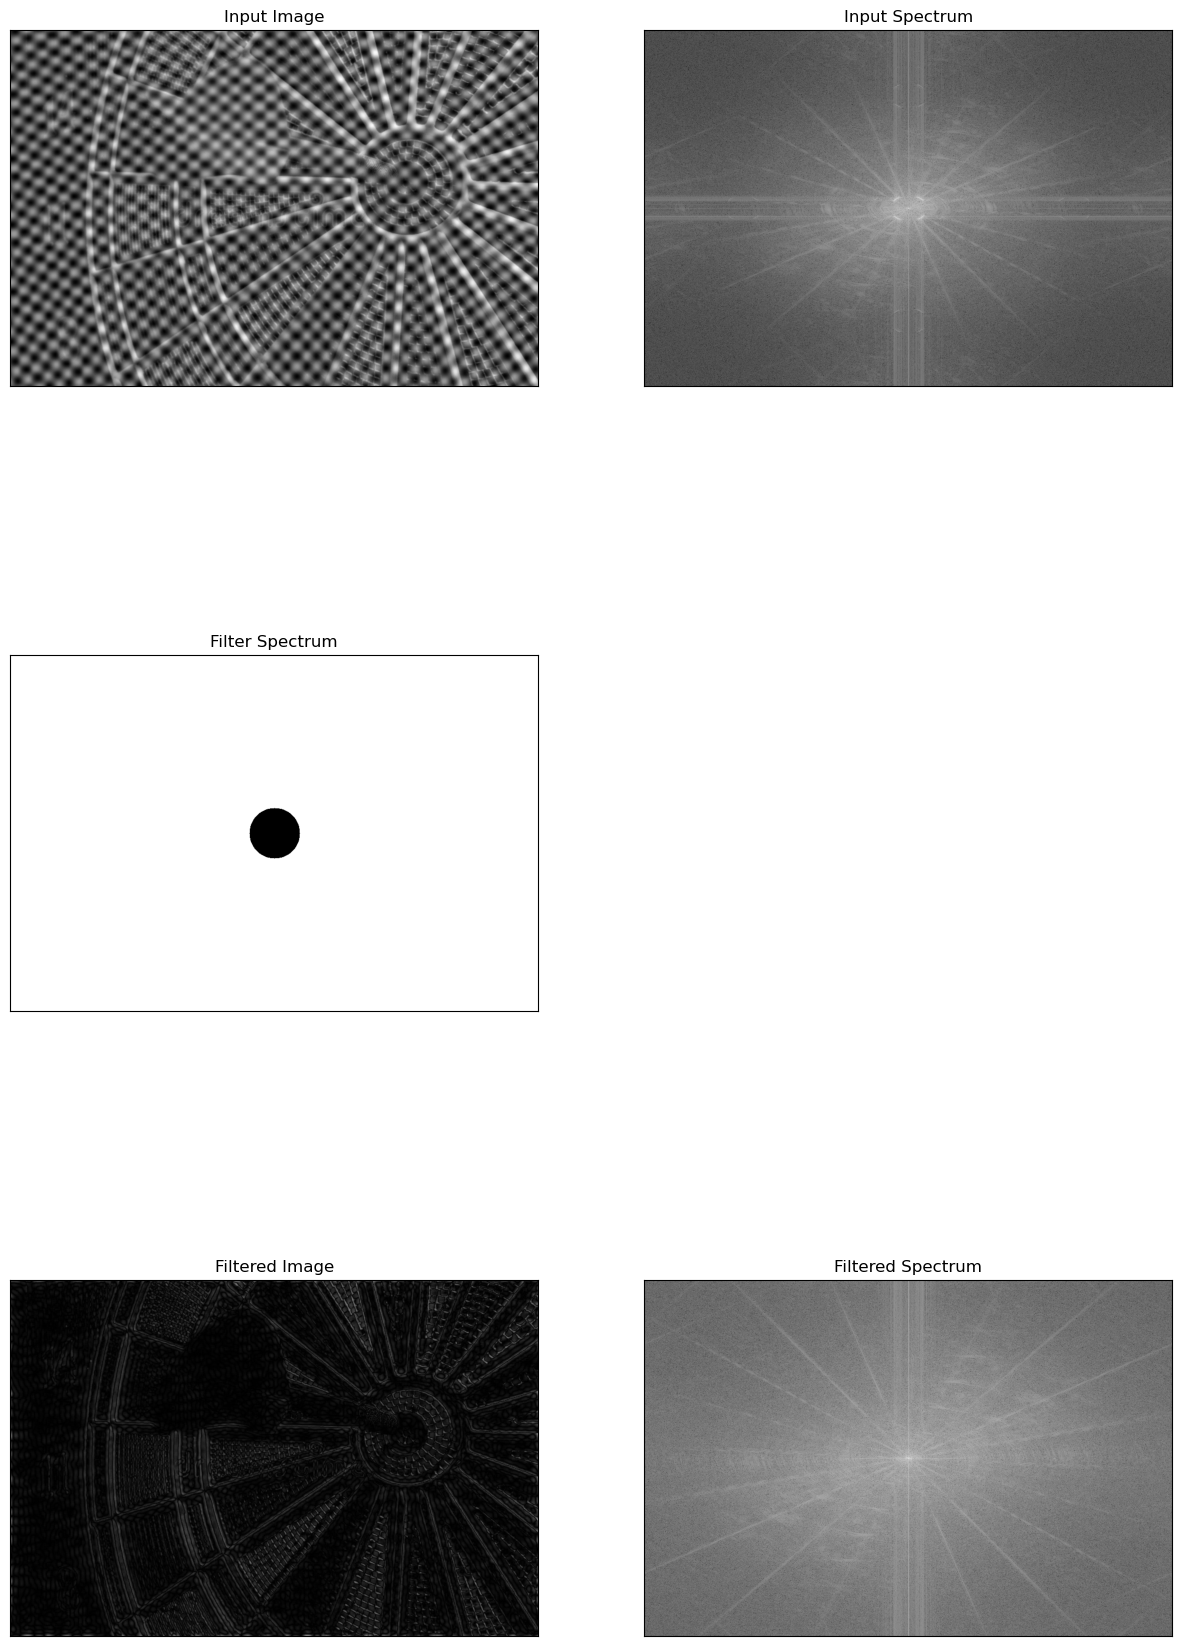

In [4]:
# fill in the following lists to compose multiple notch filters

d0_list = [50, 25]
u_k_list = [0]#, -13]
v_k_list = [0]#, 13]

H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux
    
# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

img_back *= (255.0/img_back.max())
print(img, img_back)
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


cv2.imwrite('imgComFiltrosNotch.png', img_back)
imgNotch = img_back.astype(np.uint8)


# Detecao de Linhas

## Fundamentação

Uma vez que num alvo temos linhas que acabam por se intercetar no centro, decidimos, com o objetivo de detetar o centro, detetar essas linhas e ultimamente calcular a interceção das mesmas, obtendo assim o centro.

Como forma de comparação, aplicamos este método na imagem original e na imagem filtrada.

## Imagem Original

True

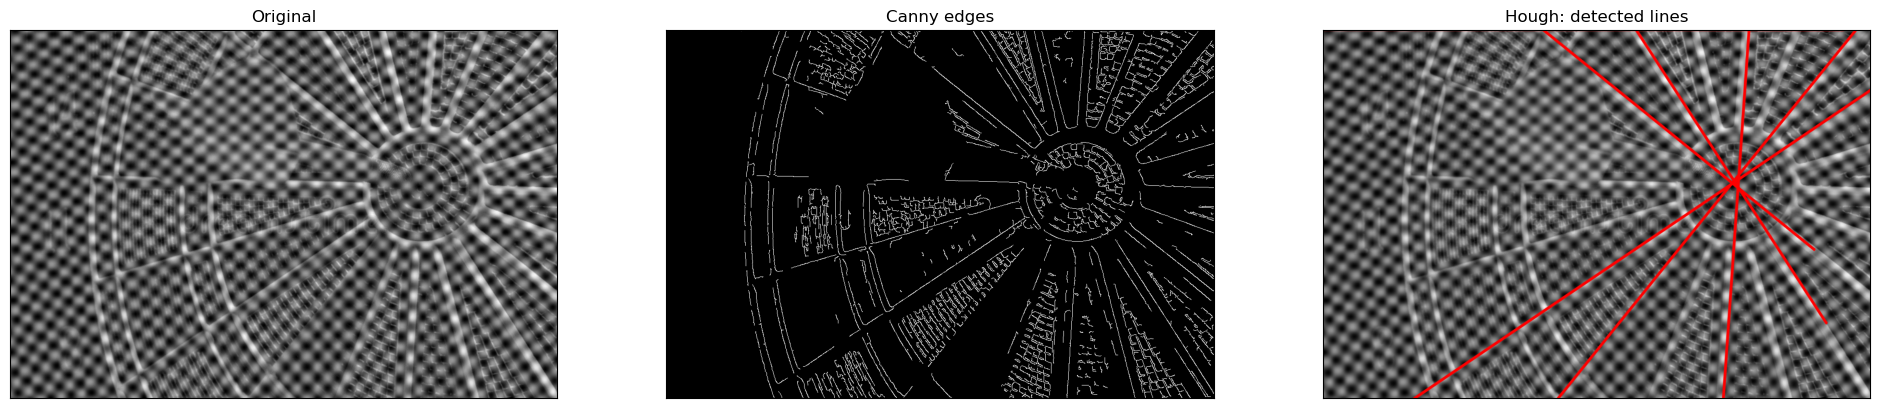

In [5]:
edges = cv2.Canny(img,100,200)
# HoughLines(image, rho_resolution, theta_resolution, how many pixels for a line)
lines_orig = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# Draw the lines
img_dst_orig = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
if lines_orig is not None:
    for i in range(0, len(lines_orig)):
        rho = lines_orig[i][0][0]
        theta = lines_orig[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_dst_orig, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)
        
fig = plt.figure(figsize=(24,8))
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(edges,cmap = 'gray')
plt.title('Canny edges'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_dst_orig,cmap = 'gray')
plt.title('Hough: detected lines'), plt.xticks([]), plt.yticks([])

cv2.imwrite('detecaoLinhasOriginal.png', img_dst_orig)

## Imagem Filtrada

[1.        1.5707964]
[686.          0.9773844]
[-506.          2.565634]
[-255.           2.2340214]
[-268.           2.2514746]
[706.          1.5707964]
[7.960000e+02 6.806784e-01]
[689.          0.9773844]
[684.          0.9773844]
[-702.           2.8972466]
[-516.           2.5830872]


True

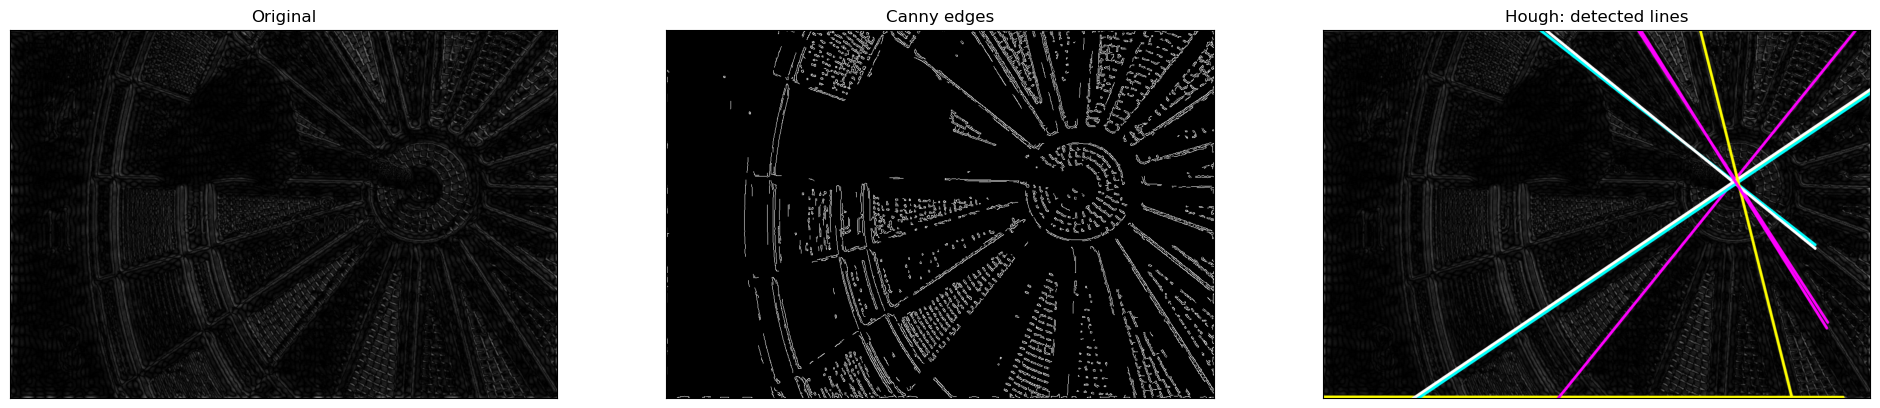

In [6]:
edges = cv2.Canny(imgNotch,100,200)
# HoughLines(image, rho_resolution, theta_resolution, how many pixels for a line)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

colors = [(255,255,255), (255, 255, 0), (255,0, 255), (0, 255, 255)]

# Draw the lines
img_dst_notch = cv2.cvtColor(imgNotch, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for i in range(0, len(lines)):
        print(lines[i][0])
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_dst_notch, pt1, pt2, colors[i%4], 3, cv2.LINE_AA)
        
fig = plt.figure(figsize=(24,8))
plt.subplot(1,3,1),plt.imshow(imgNotch,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(edges,cmap = 'gray')
plt.title('Canny edges'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_dst_notch,cmap = 'gray')
plt.title('Hough: detected lines'), plt.xticks([]), plt.yticks([])

cv2.imwrite('detecaoLinhasNotch.png', img_dst_notch)

## Interceção

Ao analisar as linhas obtidas, reparamos que, nas obtidas na imagem filtrada, temos algumas linhas que se sobrepõem, pelo que ao calcular a interceção das linhas tivemos que arranjar algum método para impedir que se tivesse em conta a interceção entre essas mesmas. Temos também linhas horizontais em cima e em baixo na imagem, que são também ignoradas.

Para o cálculo do centro final decidimos fazer uma média entre todos os pontos de interceção entre todos os pares de retas (que não sejam sobrepostas).

Para detetar se duas retas se sobrepõem decidimos criar uma variável *EPSILON* que é utilizada como o espaçamento mínimo entre o ângulo de duas retas para que estas não se considerem sobrepostas.

In [7]:
def hough_inter(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    return tuple(np.linalg.lstsq(A, b)[0].astype(np.uint32))

EPSILON: int = 0.1

def calculate_center(img, lines, filename: str):

    pairs = []

    for line, i in zip(lines, range(0, len(lines))):
        for line2, j in zip(lines, range(0, len(lines))):
            if i != j and abs(line[0][1] - line2[0][1]) >= EPSILON:
                pairs.append((line, line2))
                

    centers = []
    for l1, l2 in pairs:
        center = hough_inter(l1[0][1], l1[0][0], l2[0][1], l2[0][0])
        if center[0] <= 10 or center[0] >= img.shape[1] - 10:
            continue
        if center[1] <= 10 or center[1] >= img.shape[0] - 10:
            continue
        centers.append(center)

    center = [0, 0]
    for p in centers:
        center[0] += p[0]
        center[1] += p[1]

    center[0] = center[0] // len(centers)
    center[1] = center[1] // len(centers)

    # for center in centers:
    img2 = cv2.circle(img, tuple(center), 5, (0, 0, 255), 2)
    cv2.imwrite(filename, img2)
    return tuple(center)

def drawIntersections(img, lines, filename: str):
    pairs = []

    for line, i in zip(lines, range(0, len(lines))):
        for line2, j in zip(lines, range(0, len(lines))):
            if i != j and abs(line[0][1] - line2[0][1]) >= EPSILON:
                pairs.append((line, line2))
                

    centers = []
    for l1, l2 in pairs:
        center = hough_inter(l1[0][1], l1[0][0], l2[0][1], l2[0][0])
        if center[0] <= 10 or center[0] >= img.shape[1] - 10:
            continue
        if center[1] <= 10 or center[1] >= img.shape[0] - 10:
            continue
        centers.append(center)

    img2 = img.copy()
    for p in centers:
        # for center in centers:
        img2 = cv2.circle(img2, tuple(p), 5, (0, 0, 255), 2)

    cv2.imwrite(filename, img2)

# drawIntersections(img_dst, lines, "completo.png")
print(calculate_center(img_dst_notch, lines, "intersecoesDemorado.png"))
print(calculate_center(img_dst_orig, lines_orig, "intersecoesRapido.png"))
drawIntersections(img_dst_notch, lines, "linhasNotch.png")
drawIntersections(img_dst_orig, lines_orig, "linhasOrig.png")

(791, 294)
(791, 294)


/tmp/ipykernel_75770/2618964624.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return tuple(np.linalg.lstsq(A, b)[0].astype(np.uint32))


# Resultado Final

Correndo a célula acima e olhando para o seu *output* verificamos que, quer para a imagem inicial, quer para a imagem filtrada, o centro encontrado é nas coordenadas **(791, 294)**.

São também geradas imagens em todos os passos para mais fácil visualização.